**Pix2Pix 도로 스케치 이미지로 도로 실사 이미지 생성하기**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

---
**데이터셋**

In [2]:
## 데이터 불러오기

# 경로 지정
train_path = '/content/drive/MyDrive/aiffel/cityscapes/train/'
valid_path = '/content/drive/MyDrive/aiffel/cityscapes/val/'

# 크기 확인
print('train data :', len(os.listdir(train_path)))
print('valid data :', len(os.listdir(valid_path)))

train data : 1000
valid data : 5


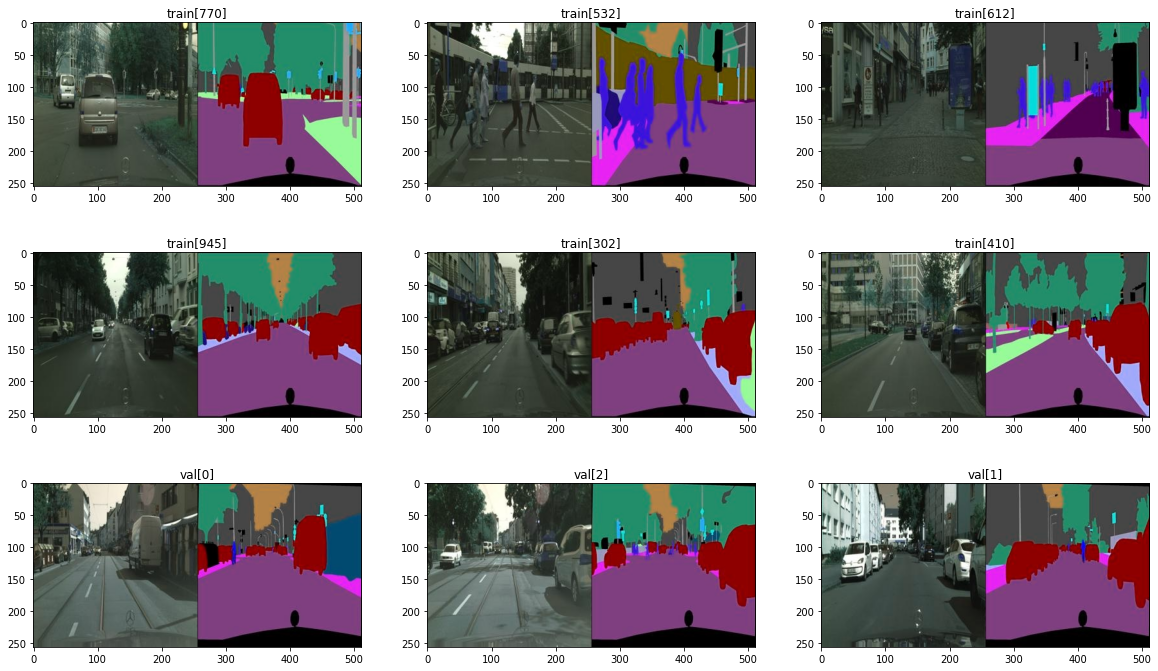

In [3]:
## 이미지 미리보기

plt.figure(figsize=(20,12))

# 학습용 이미지 6개
for i in range(6):
    idx = np.random.randint(1000)
    f = train_path + os.listdir(train_path)[idx]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 3, i + 1)
    plt.title(f'train[{idx}]')
    plt.imshow(img)

# 시험용 이미지 3개
for i in range(3):
    idx = np.random.randint(5)
    f = valid_path + os.listdir(valid_path)[idx]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 3, i + 7)
    plt.title(f'val[{idx}]')
    plt.imshow(img)

In [4]:
## 이미지 형식 확인

# 훈련 이미지
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print('train img shape', img.shape)

# 시험 이미지
f = valid_path + os.listdir(valid_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print('valid img shape', img.shape)

train img shape (256, 512, 3)
valid img shape (256, 512, 3)


* 하나의 데이터에 두 이미지가 나열되어 있습니다.
* (256, 256, 3) 크기의 두 데이터로 분리가 필요합니다.

In [5]:
## 데이터 전처리

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(f):
    img = tf.io.read_file(f)
    img = tf.image.decode_image(img, 3)

    w = tf.shape(img)[1] // 2
    origin = img[:, :w, :]
    origin = tf.cast(origin, tf.float32)
    style = img[:, w:, :]
    style = tf.cast(style, tf.float32)
    
    return normalize(origin), normalize(style)

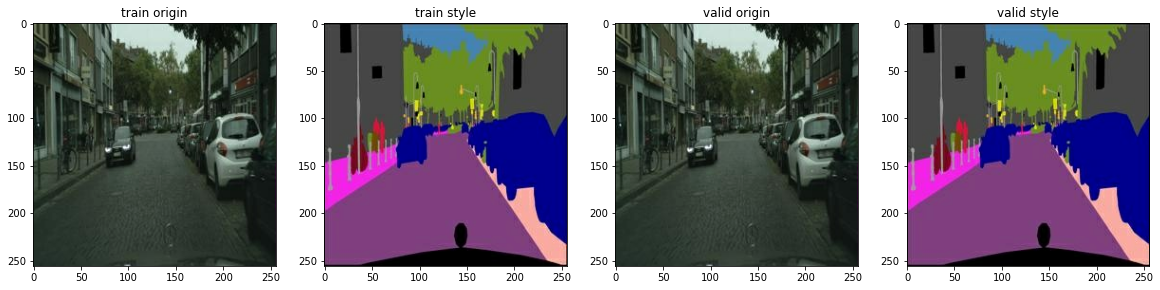

In [6]:
## 데이터 전처리
f = train_path + os.listdir(train_path)[1]
origin, style = load_img(f)

f2 = valid_path + os.listdir(valid_path)[1]
origin2, style2 = load_img(f)

# 미리보기
plt.figure(figsize=(20, 8))
plt.subplot(141); plt.title('train origin'); plt.imshow(denormalize(origin))
plt.subplot(142); plt.title('train style'); plt.imshow(denormalize(style))
plt.subplot(143); plt.title('valid origin'); plt.imshow(denormalize(origin2))
plt.subplot(144); plt.title('valid style'); plt.imshow(denormalize(style2))

In [7]:
## Augmentation
@tf.function()
def apply_augmentation(origin, style):
    stacked = tf.concat([origin, style], axis=-1)

    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, 'REFLECT')
    else:
        padded = tf.pad(stacked, _pad, 'CONSTANT', constant_values=1.)

    out = tf.image.random_crop(padded, size=[256, 256, 6])
    out = tf.image.random_flip_left_right(out)
    out = tf.image.random_flip_up_down(out)

    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = tf.image.rot90(out, k=degree)
    
    return out[..., :3], out[..., 3:]

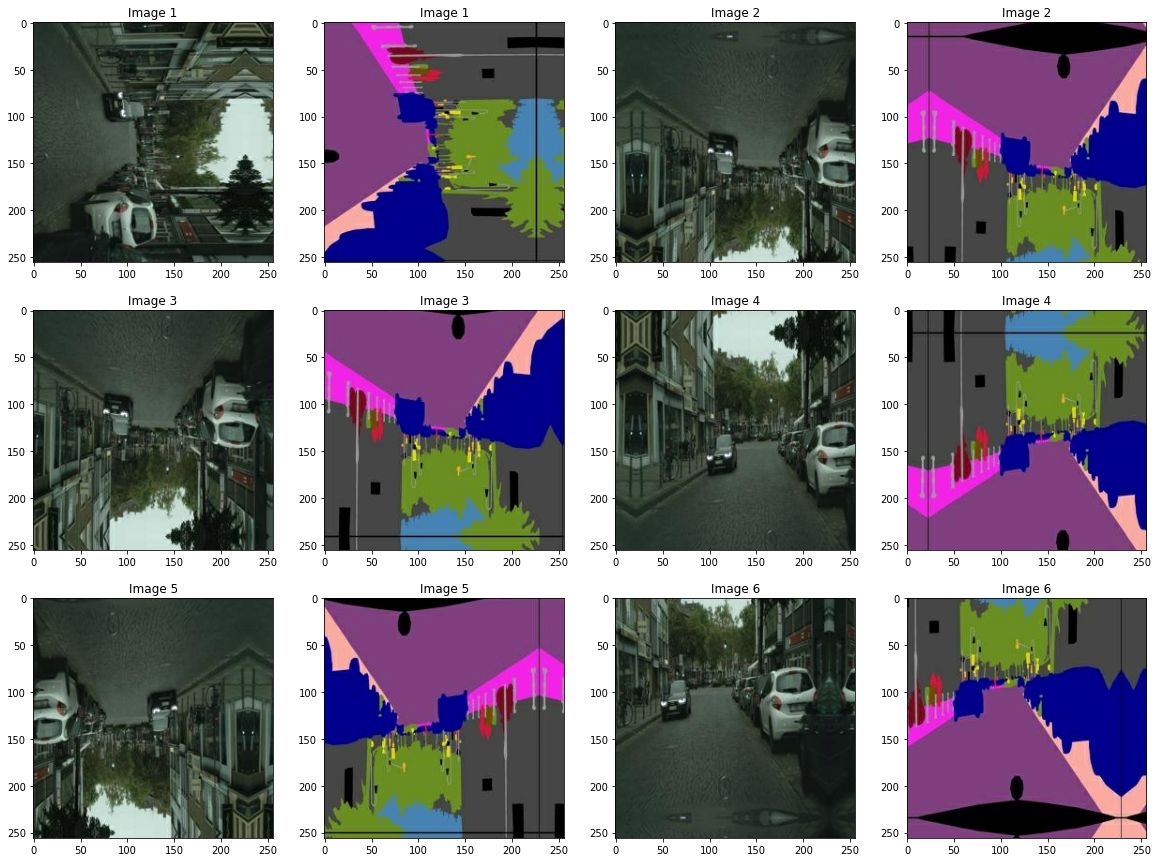

In [8]:
## Augmentation 확인

plt.figure(figsize=(20, 15))
n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(origin, style)
    
    plt.subplot(3, 4, i); plt.title(f"Image {n}")
    plt.imshow(denormalize(augmented_sketch))
    plt.subplot(3, 4, i + 1); plt.title(f"Image {n}")
    plt.imshow(denormalize(augmented_colored))

    n += 1

In [9]:
## 데이터셋 구축
def get_train(f):
    origin, style = load_img(f)
    origin, style = apply_augmentation(origin, style)
    return origin, style

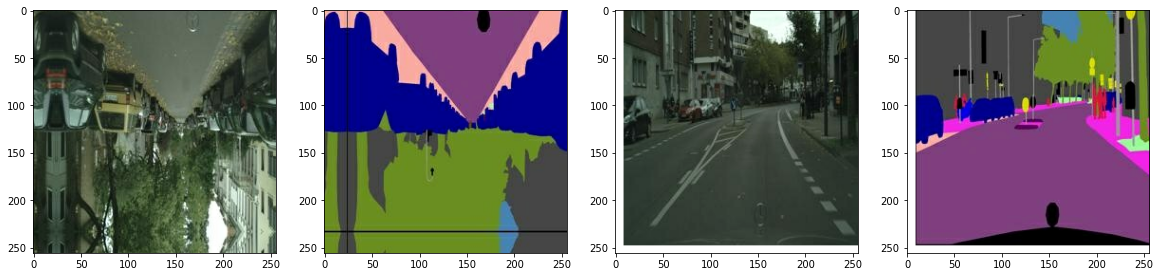

In [10]:
## 데이터셋 구축
train_img = tf.data.Dataset.list_files(train_path + "*.jpg")
train_img = train_img.map(get_train).shuffle(100).batch(4)

# 미리보기
sample = train_img.take(1)
sample = list(sample.as_numpy_iterator())
origin, style = (sample[0][0] + 1) * 127.5, (sample[0][1] + 1) * 127.5

sample2 = train_img.take(1)
sample2 = list(sample2.as_numpy_iterator())
origin2, style2 = (sample2[0][0] + 1) * 127.5, (sample2[0][1] + 1) * 127.5

plt.figure(figsize=(20, 8))
plt.subplot(1, 4, 1); plt.imshow(origin[0].astype(np.uint8))
plt.subplot(1, 4, 2); plt.imshow(style[0].astype(np.uint8))
plt.subplot(1, 4, 3); plt.imshow(origin2[0].astype(np.uint8))
plt.subplot(1, 4, 4); plt.imshow(style2[0].astype(np.uint8))

---
**모델링**

In [11]:
## Generator (U-Net Generator)

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn: x = self.batchnorm(x)
        x = self.lrelu(x)
        return x
    

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout: x = layers.Dropout(.5)(x)
        x = self.relu(x)
        return x


class UNetGenerator(tf.keras.Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]

        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0: self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else: self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3: self.decode_blocks.append(DecodeBlock(f))
            else: self.decode_blocks.append(DecodeBlock(f, dropout=False))

        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)

    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        features = features[:-1]

        for block, feature in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feature])
        
        x = self.last_conv(x)
        return x

    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = tf.kears.Input(input_shape)
        return tf.keras.Model(inputs, self.call(inputs)).summary()

In [12]:
## Discriminator

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act = True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act

        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None

    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
        
        if self.use_bn: x = self.batchnorm(x)
        if self.act: x = self.lrelu(x)

        return x


class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.sigmoid(out)
        return out
    
    def get_summary(self, x_shape=(256, 256, 3), y_shape=(256, 256, 3)):
        x, y = tf.keras.Input(x_shape), tf.keras.Input(y_shape)
        return tf.keras.Model((x, y), self.call(x, y)).summary()


In [13]:
## 모델 학습 준비

# 손실 함수
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mae = tf.keras.losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    loss_gene = bce(tf.ones_like(fake_disc), fake_disc)
    loss_l1 = mae(real_output, fake_output)
    return loss_gene + (100 * loss_l1)

def get_disc_loss(fake_disc, real_disc):
    loss_fake = bce(tf.zeros_like(fake_disc), fake_disc)
    loss_real = bce(tf.ones_like(real_disc), real_disc)
    return loss_fake + loss_real

# 최적화 함수
gene_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

# 학습 과정
@tf.function
def train_step(origin, style):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        fake_gene = generator(style, training=True)

        fake_disc = discriminator(style, fake_gene, training=True)
        real_disc = discriminator(style, origin, training=True)

        gene_loss = get_gene_loss(fake_gene, origin, fake_disc)
        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(gene_loss, generator.trainable_variables)
    dics_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(dics_gradient, discriminator.trainable_variables))

    return gene_loss, disc_loss

In [14]:
## 모델 학습

EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS + 1):
    for i, (origin, style) in enumerate(train_img):
        g_loss, d_loss = train_step(origin, style)

    print(f"EPOCH[{epoch}]")
    print("{:<20} {:<20}".format("Generator loss", g_loss.numpy()))
    print("{:<20} {:<20}".format("Discriminator loss", d_loss.numpy()))
    print()

EPOCH[1]
Generator loss       18.60110855102539   
Discriminator loss   1.2754294872283936  

EPOCH[2]
Generator loss       19.33531951904297   
Discriminator loss   1.1785858869552612  

EPOCH[3]
Generator loss       20.897018432617188  
Discriminator loss   0.9172008037567139  

EPOCH[4]
Generator loss       19.68476676940918   
Discriminator loss   0.5097284317016602  

EPOCH[5]
Generator loss       24.897920608520508  
Discriminator loss   1.2137513160705566  

EPOCH[6]
Generator loss       18.16338539123535   
Discriminator loss   0.5427356362342834  

EPOCH[7]
Generator loss       17.082744598388672  
Discriminator loss   1.334933876991272   

EPOCH[8]
Generator loss       20.438838958740234  
Discriminator loss   0.9388133883476257  

EPOCH[9]
Generator loss       20.64316749572754   
Discriminator loss   0.5833275318145752  

EPOCH[10]
Generator loss       19.412023544311523  
Discriminator loss   0.3397385776042938  

EPOCH[11]
Generator loss       16.832759857177734  
Discrim

---
**결과**

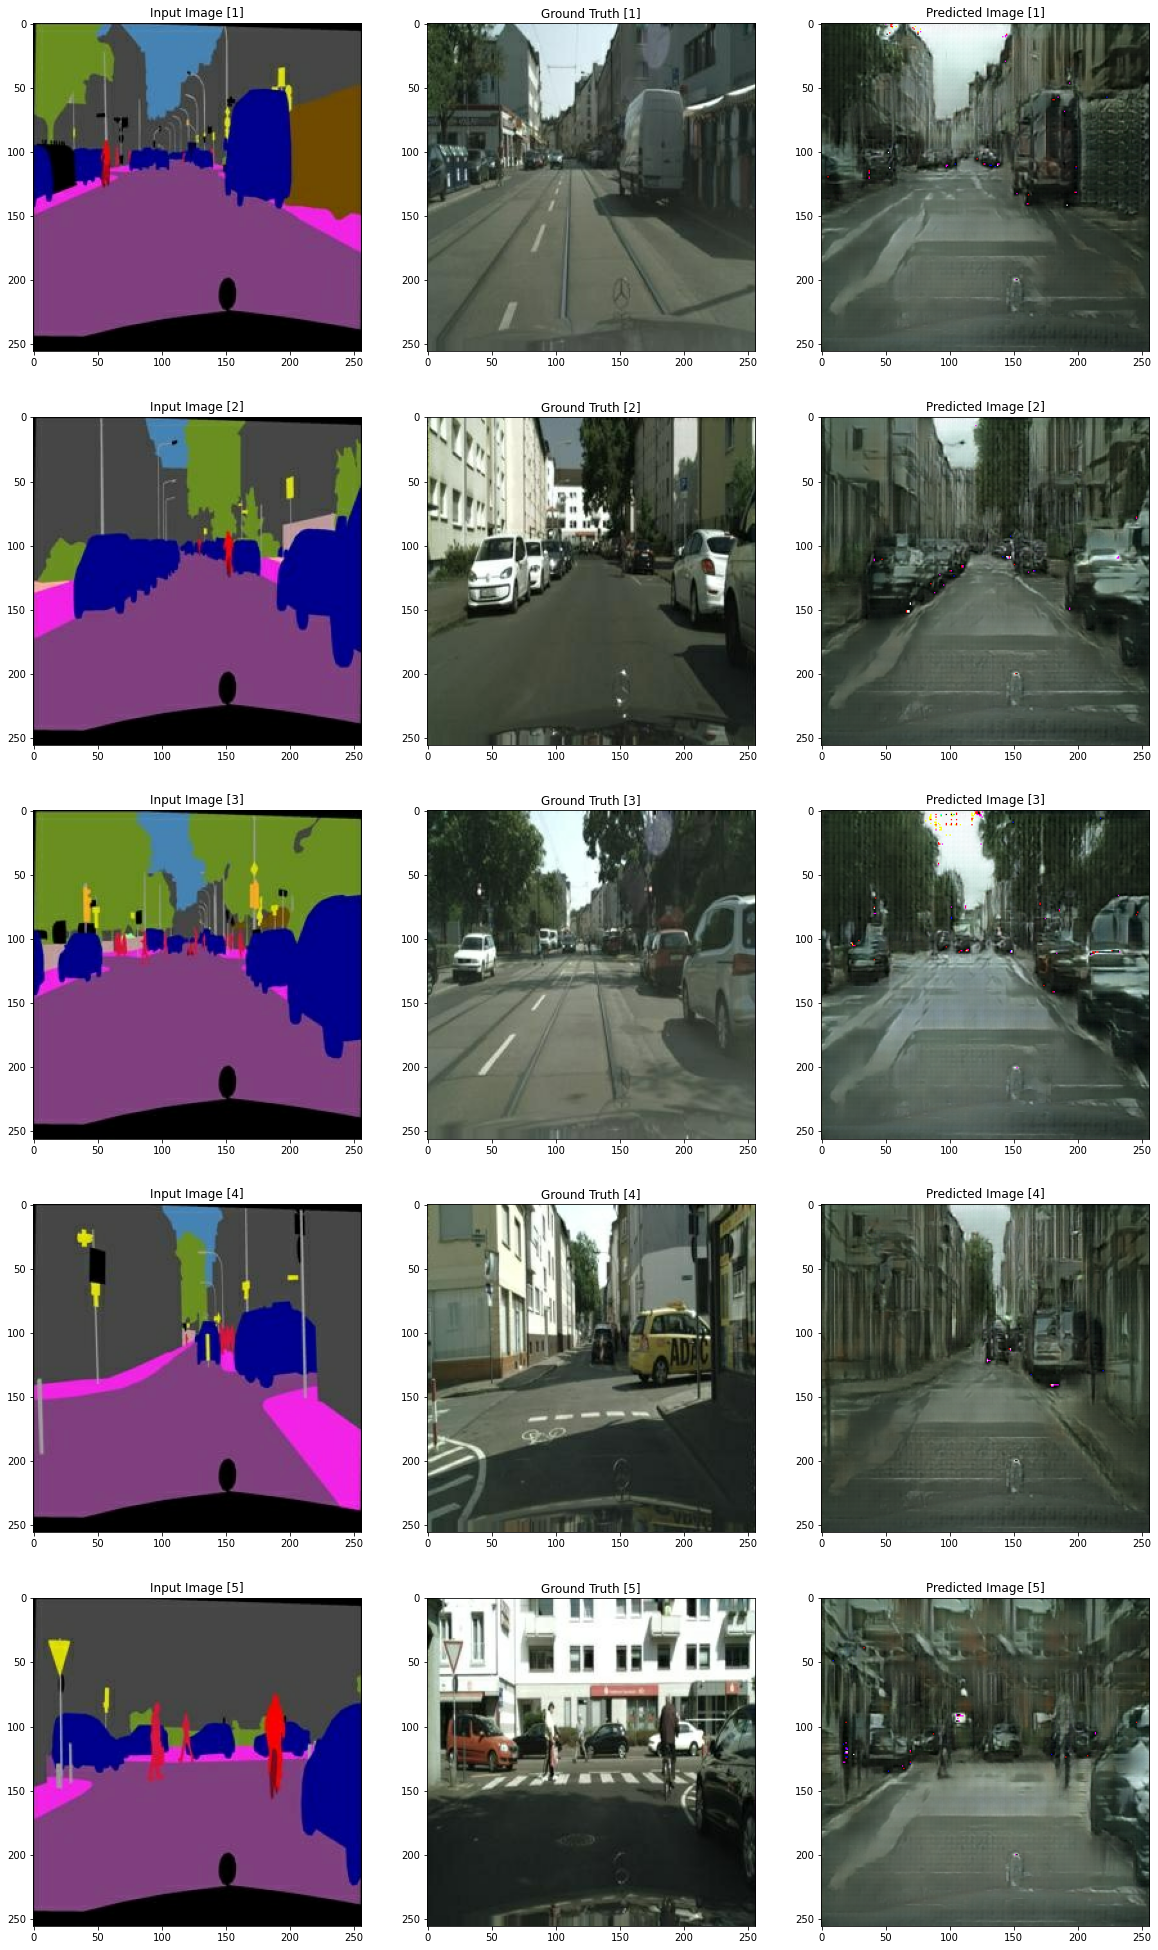

In [15]:
plt.figure(figsize=(20, 35))
for i in range(5):
    f = valid_path + os.listdir(valid_path)[i]
    origin, style = load_img(f)
    
    pred = generator(tf.expand_dims(style, 0))
    pred = denormalize(pred)

    plt.subplot(5, 3, 3 * i + 1); plt.title(f'Input Image [{i + 1}]'); plt.imshow(denormalize(style))
    plt.subplot(5, 3, 3 * i + 2); plt.title(f'Ground Truth [{i + 1}]'); plt.imshow(denormalize(origin))
    plt.subplot(5, 3, 3 * i + 3); plt.title(f'Predicted Image [{i + 1}]'); plt.imshow(pred[0])

---
**프로젝트 평가**

* EPOCHS를 200으로 설정하였을 때 Input Image로부터 그럴듯한 Predicted Image를 얻을 수 있었습니다.
* 다만, 원본 이미지인 Ground Truth와 유사한 이미지라기보다는 Input Image에 부합하는 새로 생성된 Predicted Image에 가깝습니다.
* 따라서 원본 이미지를 원복하는 목적이 아닌 스케치로부터 실사 이미지를 얻을 필요가 있을 때 사용할 수 있습니다.
* 아쉬운 점은 epoch에 따라서 손실(generator loss와 discriminator loss)이 점차 감소하는 형태가 아니라는 것입니다.
* loss를 중요한 지표로 본다면 generator가 생성한 모델을 discriminator가 판별할 때는 훈련하지 않도록 (training=False) 할 필요가 있어 보입니다.